# CIS 545 Homework 5: Deep Learning with MXNet

### Due Monday, ***April 18, 10:00 EST***

Welcome to CIS 545 Homework 5! 

In this homework, we will learn more about the 'new electricity' - Deep Learning (I didn't coin this, Andrew Ng did) ! There are many cool frameworks for building deep learning models - PyTorch, Tensorflow, Theano, MxNet. Since you will be working with Big Data in this course, you need a framework that scales well. Almost all of these have a multi-gpu support built in, MxNet provides the easiest abstractions to do this and works well with AWS. In this assignment, we will be building neural networks in MxNet to solve an interesting problem.

Deep learning or neural network architectures have been used to solve a multitude of problems in various different fields like vision, natural language processing. So let's take a 'deep' dive into it.


![alt text](http://4.bp.blogspot.com/-sLgBLS3bJO8/U__Kx6PnkRI/AAAAAAAAAWM/Gz3cL5jiwTo/s320/godeeper.jpg)





## Why deep learning? 


*   It's coooool
*   Everyone is talking about is these days, People like Siraj Raval can teach it in 5 mins (Check out his youtube channel for some comedy)
*    Deep learning unlocks the treasure trove of unstructured big data for those with the imagination to use it
*   Deep learning models have great representational power and are 'universal approximators'


### Deep Learning Applications:


Deep learning has been significantly improved voice command systems (such as Siri and Alexa), as well as healthcare and image identification.

Deep learning has applications across numerous industries, which is why experts think that this technology is the future of almost everything. There are truly deep learning technologies such as Google’s very human-like talking AI, a new theory that cracks the 'black box' of deep learning, and various budding ideas like this one about why human forgetting might be the key to AI. Here are some cool applications of deep learning - 

Here's a neural network detecting anomalies in Chest Xrays :




![alt text](https://imgur.com/HKPzrzP.jpg)

Most humans can't tell that this is a case of Pleural Effusion {sounds like medical jargon to engineers like us} but this Neural Network model can detect it very well!

Mask RCNNs in action for detecting objects on the road aiding a self driving vehicle's driving: 
![alt text](https://miro.medium.com/max/3864/1*O4wsvh0CHWjP6IrK9HI_Zg.png)

Pretty cool, right? We will be appling CNNs to solve a cool image classification problem.


# Setup Jargon


## Penn Grader Setup
Make sure to initialize the grader with your 8 digit Penn ID.

In [2]:
%%capture
!pip3 install penngrader

from penngrader.grader import *

VERY IMPORTANT : Enter your **8 digit Penn ID** in the student id field below

PLEASE NOTE: There are some questions, for example making plots, that do not have test cases. All questions without an autograder attached will be manually graded. 

In [3]:
#PLEASE ENSURE YOUR PENN-ID IS ENTERED CORRECTLY. IF NOT, THE AUTOGRADER WON'T KNOW WHO 
#TO ASSIGN POINTS TO YOU IN OUR BACKEND
STUDENT_ID = 67380955 # YOUR PENN-ID GOES HERE AS AN INTEGER#

In [4]:
grader = PennGrader(homework_id = 'CIS545_Spring_2022_HW5', student_id = STUDENT_ID)

PennGrader initialized with Student ID: 67380955

Make sure this correct or we will not be able to store your grade


## MxNet Installation

In [5]:
!nvidia-smi

Thu Apr 21 02:48:24 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
%%capture
!pip3 install --upgrade mxnet-cu101 gluoncv

In [7]:
import mxnet as mx
from gluoncv.utils import viz
from mxnet.gluon.data import DataLoader
from mxnet.gluon.data.vision import transforms
from mxnet import np
import shutil
import os
import glob
import seaborn as sns
import pandas as pd
import numpy as np

/usr/local/lib/python3.7/dist-packages/gluoncv/__init__.py:40: UserWarning: Both `mxnet==1.9.0` and `torch==1.10.0+cu111` are installed. You might encounter increased GPU memory footprint if both framework are used at the same time.
  warnings.warn(f'Both `mxnet=={mx.__version__}` and `torch=={torch.__version__}` are installed. '


In [8]:
from mxnet import np, npx
from mxnet.gluon import nn
npx.set_np()

npx.num_gpus()

1

Downloading/Unzipping Dataset

In [9]:
!wget -nc https://storage.googleapis.com/penn-cis545/hw5_data.zip -O data.zip
!unzip -q "data.zip"

--2022-04-21 02:49:17--  https://storage.googleapis.com/penn-cis545/hw5_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 209.85.200.128, 209.85.234.128, 108.177.112.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|209.85.200.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13527975 (13M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]  12.90M  --.-KB/s    in 0.1s    

2022-04-21 02:49:17 (117 MB/s) - ‘data.zip’ saved [13527975/13527975]



#Section 1: Traffic Sign Classification with MxNet

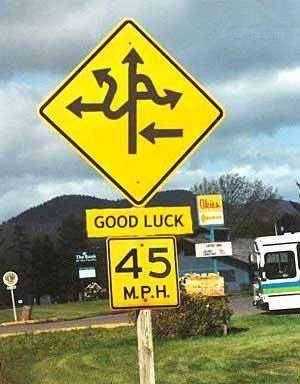

In this homework we will tackle one small subset of various problems in developing Autonomous Vehicle system. That is detecting the meaning of traffic signs!

The dataset we'll use is used for traffic sign classification problem. Multi-class image classification is a challenging problem in computer vision, especially when the number of classes is large. The two main difficulties with this specific problem is the subtle differences within label (different images of the same traffic sign) and across different labels. 

####[Differences within label]
For a single traffic sign there exists many variations. Some signs have yellow background colors while for others the background color could be white or blue. We need to train a model that recognizes that these differences are just variances in the label distribution and still predict correctly. 

####[Differences between label]
Traffic signs with small difference could have completely different meanings (ex - speed limit traffic signs). Our trained model should also be able to recognize these difference between labels to make accurate predictions.


The dataset contains 43 traffic sign labels. All images are in jpg format.



## 1.1.1 Summarizing our Dataset (5 points)

Getting a good sense of the dataset we are going to work on is always the first step you should take when implemening ML applications. 

Using the paths given (base_path, train_path, test_path)

1. Get the number of labels in training dataset and save as "train_num_labels" 

2. Create a dictionary "train_dataset_dict" that contains the labels as keys and the number of images inside the label as values.

Hint: Look up the documentation for os.walk




In [10]:
base_path = '/content/data_file_final'
train_path = os.path.join(base_path, 'train/')
test_path = os.path.join(base_path,'validation/')

# TODO - Number of labels for train dataset
train_num_labels = len(os.walk(train_path).__next__()[1])

# TODO - Creating dictionary for train dataset 
filenums = []
for i in os.walk(train_path).__next__()[1]:
  # n = sum([len(x) for _, _, x in os.walk(os.path.dirname(i))])
  sub_path = os.path.join(train_path, i)
  n = len(os.walk(sub_path).__next__()[2])
  filenums.append(n)

train_dataset_dict = dict(zip(os.walk(train_path).__next__()[1], filenums))

In [11]:
train_dataset_dict

{'Ahead only': 256,
 'Beware of icesnow': 221,
 'Bicycles crossing': 222,
 'Bumpy road': 240,
 'Children crossing': 231,
 'Dangerous curve to the left': 245,
 'Dangerous curve to the right': 256,
 'Double curve': 212,
 'End of all speed and passing limits': 228,
 'End of no passing': 234,
 'End of no passing by vehicles over 3.5 metric tons': 230,
 'End of speed limit (80kmh)': 227,
 'General caution': 213,
 'Go straight or left': 226,
 'Go straight or right': 224,
 'Keep left': 219,
 'Keep right': 223,
 'No entry': 254,
 'No passing': 228,
 'No passing for vehicles over 3.5 metric tons': 220,
 'No vehicles': 223,
 'Pedestrians': 240,
 'Priority road': 244,
 'Right-of-way at the next intersection': 218,
 'Road narrows on the right': 228,
 'Road work': 235,
 'Roundabout mandatory': 234,
 'Slippery road': 248,
 'Speed limit (100kmh)': 236,
 'Speed limit (120kmh)': 246,
 'Speed limit (20kmh)': 253,
 'Speed limit (30kmh)': 237,
 'Speed limit (50kmh)': 219,
 'Speed limit (60kmh)': 234,
 'Sp

In [12]:
train_num_labels

43

In [13]:
grader.grade('check_train_dataset', (train_num_labels, train_dataset_dict)) 

Correct! You earned 3/3 points. You are a star!

Your submission has been successfully recorded in the gradebook.


Implement the same procedure for the test dataset and save it to "test_num_labels" and "test_dataset_dict"

In [14]:
# TODO - Number of labels for test dataset
# TODO - Creating dictionary for test dataset 
test_dataset_dict = {}
for root, dirs, files in os.walk(test_path):
  if len(dirs) == 0:
    test_dataset_dict[os.path.basename(root)] = len(files)
test_num_labels = len(test_dataset_dict)

In [15]:
grader.grade('check_test_dataset', (test_num_labels, test_dataset_dict))

Correct! You earned 2/2 points. You are a star!

Your submission has been successfully recorded in the gradebook.


## 1.1.2 Dataset Distribution visualization (Train) (5 pts)

Create a seaborn barplot of the labels as well as the occurence of their frequencies of the train dataset. Add labels and titles and edit fontsize appropriately so the axis labels can be seen. This section will be manually graded.

(Don't worry about the visualibility of the each label names. Since this is a long barplot)

[Text(0, 0.5, 'Frequency'),
 Text(0.5, 0, 'Label'),
 Text(0.5, 1.0, 'Label Frequency of Training Set')]

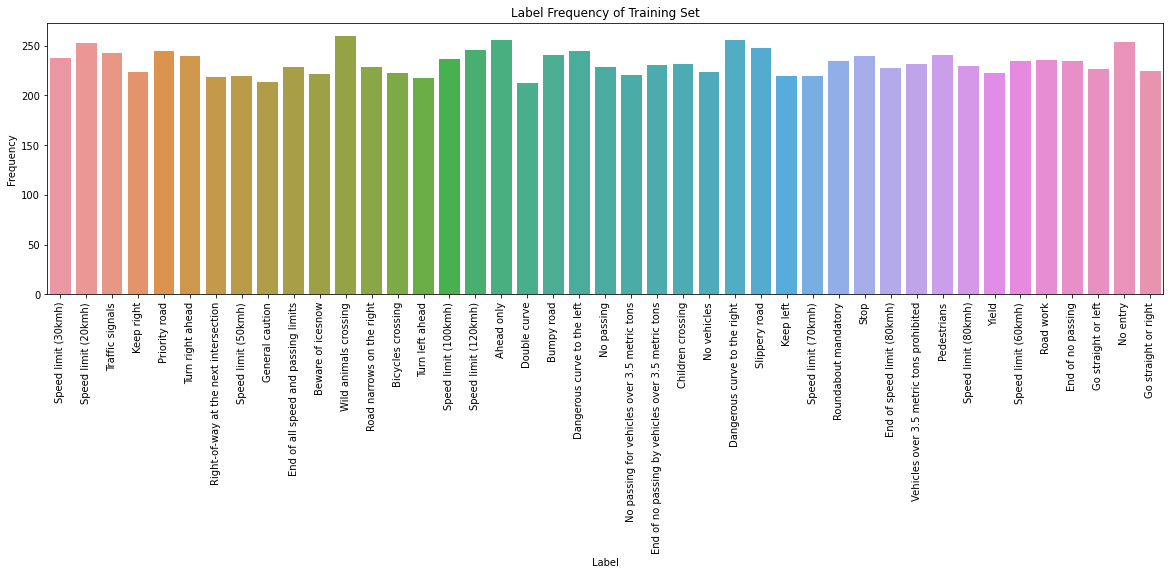

In [16]:
# TODO - Create Seaborn Barplot
import matplotlib.pyplot as plt
plt.figure(figsize=(20,5))
plt.xticks(rotation = 90)
keys = list(train_dataset_dict.keys())
vals = [float(train_dataset_dict[k]) for k in keys]
p = sns.barplot(x=keys, y=vals)
p.set(xlabel="Label", ylabel="Frequency", title = 'Label Frequency of Training Set')

Does the class distribution look relatively uniform? If yes, we don't need to address class imbalance, if no, what should we do?

## 1.1.3 Build a dataset class (2pts)

Create train and test datasets for loading image files stored in a folder structure within train_path and test_path. Make sure that the image pixels  are floats in range [0,1] and not integers between [0,255] (Hint: transform parameter)

You should name your datasets train_dataset and test_dataset

Read about how you can do it [here](https://mxnet.apache.org/versions/1.0.0/api/python/gluon/data.html).

For the test case, index the ***205th*** image and get the labels for ***both*** train and test datasets and assign them to sample_train_label and sample_test_label, respectively. 

In [17]:
# TODO
from mxnet.gluon.data.vision import ImageFolderDataset
train_dataset = ImageFolderDataset(train_path, transform = lambda data, label: (data.astype(np.float32)/255, label))
test_dataset = ImageFolderDataset(test_path, transform = lambda data, label: (data.astype(np.float32)/255, label))

In [18]:
# TODO - samples
sample_train_label = train_dataset[205][1]
sample_test_label = test_dataset[205][1]

In [19]:
grader.grade('check_datasets', [sample_train_label, sample_test_label])

Correct! You earned 2/2 points. You are a star!

Your submission has been successfully recorded in the gradebook.


## 1.1.3 Visualize images from the dataset (5 pts)

We have our training and testing datasets but we humans don't really understand binary that well. So let's visualize what our training data looks like by plotting some data points. 

Play around with how to access data from the dataset and then plot some of them (Hint: Look at plt.imshow()). This section will be manually graded, so be sure to give the images titles!

We have given you the sample_idxs which are indexs of the images you should visualize from the train_dataset you have implemented above.

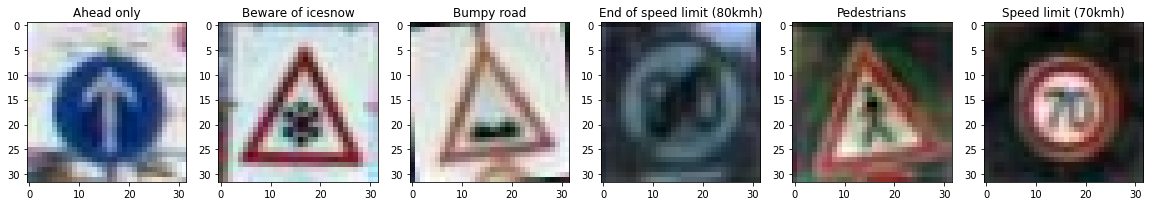

In [20]:
from IPython.core.pylabtools import figsize
# TODO - Visualize 6 images in the dataset with their label using sample_idxs
%matplotlib inline

import matplotlib.pyplot as plt
sample_idxs = [10, 300, 700, 2705, 5005, 8000]

fig, axes = plt.subplots(1, len(sample_idxs), figsize=(20,8))
for i in range(len(sample_idxs)):
  axes[i].imshow(train_dataset[sample_idxs[i]][0].asnumpy())
  label = train_dataset[sample_idxs[i]][1]
  axes[i].set_title(train_dataset.synsets[label])


## 1.1.4 Create Dataloader objects (4 points)


Data loaders create data batches and perform transformations on the images. 

Write a transformation to resize the image to 32 x 32. You would also need to add a transformation to convert the image to a tensor - building blocks of neural network operations. Tensors are like numpy arrays with a gradient aspect. 

TLDR, in this section you will need to
 
*   Define a composition of transformations to first resize the image (to 32 x 32) and then convert to tensors
*   Next create train and test data loaders ("train_loader", "test_loader"), apply the transformations to the train and test datasets respectively. You will also need to pass in the batch size and whether or not you want to shuffle the data. 
*   Set shuffle = True for the train and False for the test set.
*   Use a batch size of 32 for the train loader and a batch size of 1 for the test set.

[Refer](https://mxnet.apache.org/api/python/docs/api/gluon/data/vision/transforms/index.html#mxnet.gluon.data.vision.transforms.Compose) to the transformation documentation


In [21]:
from mxnet.gluon.data import DataLoader
from mxnet.gluon.data.vision.transforms import Compose
# TODO: Define the transformation and the train and test loaders
transform = Compose([transforms.Resize(size=(32, 32)),
                     transforms.ToTensor()])
train_loader = DataLoader(train_dataset.transform_first(transform), batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset.transform_first(transform), batch_size=1, shuffle=False)

In [22]:
# For grading

answer1 = None
shape_of_train_loader = None
for data, label in train_loader:
    answer1 = data.asnumpy().shape, label.asnumpy().shape
    shape_of_train_loader = data.asnumpy().shape
    break

answer2 = None
for data, label in test_loader:
    answer2 = data.asnumpy().shape, label.asnumpy().shape
    break

grader.grade('check_loaders', (answer1, answer2))

Correct! You earned 4/4 points. You are a star!

Your submission has been successfully recorded in the gradebook.


# 2.1 Let's build classifiers!

We have the data we need to train a scene classifier. We will start simple with a logistic regression classifier as a baseline for our performance before we move onto more complex neural networks. 

## 2.1.1 Logical Logistic Regression - Baseline (20 points)

 Let's first try solving this problem with a Logistic Regression classifier solving the multiclass classification problem.

We will define a logistic regression model in Apache MxNet and train it on our training set and evaluate the performance on the test set

### Model Definition

We will define our first model in mxnet. Read up about gluon and autograd modules and how to use them to create layers in a neural network.

Our first model is a logistic regression model with the number of outputs equal to the number of classes in the model. Complete the construct net function with the logistic regression model definition

In [23]:
from mxnet import gluon, autograd, ndarray
from mxnet.gluon import nn

def construct_net():
    net = nn.Sequential() # TODO: Initialize a gluon sequential model
    with net.name_scope():
        #TODO: Add a gluon dense layer to the model
        net.add(
        nn.Dense(train_num_labels)
        )
    return net

net = construct_net()

# Set the context to use the available GPUs, otherwise just use a CPU
ctx =  mx.gpu() if mx.context.num_gpus() else mx.cpu()

Now we need to initialize the model weights and the context, call the net initialize function with Xavier Initialization (sets your starting model weights, read more about it online if you are curious) also set the ctx variable with the context defined above

In [24]:
net.initialize(mx.init.Xavier(), ctx=ctx)

Let's print the model summary

In [25]:
x = mx.sym.var('data').as_np_ndarray()
sym = net(x)
mx.viz.print_summary(sym)

________________________________________________________________________________________________________________________
Layer (type)                                        Output Shape            Param #     Previous Layer                  
data(null)                                                                  0                                           
________________________________________________________________________________________________________________________
sequential0_dense0_fwd(FullyConnected)                                      43          data                            
Total params: 43
________________________________________________________________________________________________________________________


The following test case might fail even if your have the correct parameters, restart runtime and check if you think you have the right paramters!

In [26]:
x = net(mx.nd.random.uniform(shape=shape_of_train_loader, ctx=ctx).as_np_ndarray())
grader.grade('check_log_reg_model', (x.shape, str(net.collect_params())))

Correct! You earned 2/2 points. You are a star!

Your submission has been successfully recorded in the gradebook.


This is a multi-class classification problem, so we will use the *categorical cross-entropy* loss function. It is defined as:

$$L(y,\hat y)=-\sum_{j=0}^M\sum_{i=0}^{N}(y_{ij} log(\hat y_{ij}))$$

Luckily, we don't have to write it ourselves, we will use the implementation within Mxnet and Gluon.

Let's first define our criterion i.e. the loss function we want to optimize for.

Read more about gluon loss functions [here](https://mxnet.apache.org/api/python/docs/api/gluon/loss/index.html).

In [27]:
# TODO: Define a gluon Softmax Cross Entropy object, name this 'criterion', 
# the softmax indicates that the loss function does a softmax first to get the probabilities
# and then computes the Cross EntropyLoss
criterion = mx.gluon.loss.SoftmaxCrossEntropyLoss(axis=-1) #TODO

In [28]:
grader.grade('check_criterion', str(criterion))

Correct! You earned 2/2 points. You are a star!

Your submission has been successfully recorded in the gradebook.


Next, we define a trainer object, which includes an optimizer - we will use a stochastic gradient descent optimizer to optimize for our criterion and update our weights. 
We need 3 parameters while defining a gluon optimizer. 


1.   Trainable parameters in the model - net.collect_params() gives you all these parameters
2.   An optimizer - 'sgd' or 'adam', for this task, use the adaptive moment estimation algorithm aka 'adam'
3.   Optimizer params - A dictionary with parameters for your optimizer. We only need to specify the learning rate parameter within this dictionary.

The learning rate is a hyperparameter that you should train for. You should start with a small learning rate like 0.001.

Read more about the trainer object [here](https://mxnet.apache.org/api/python/docs/api/gluon/trainer.html).




In [29]:
adam = mx.optimizer.create('adam', learning_rate=.001)
trainer = mx.gluon.Trainer(net.collect_params(), adam) #TODO

### Train Model

Next, we need to iterate through our training data multiple times to optimize our weights. Each of the iterations is called an epoch. 

We will write a training loop now. Here is the pseudocode for the training loop: 

1. Define an [accuracy metric ](https://mxnet.apache.org/api/python/docs/api/metric/index.html) to measure performance.
1.   Repeat the following for a number of epochs
2.   Iterate through the mini batches in the training dataloader
3.   Each minibatch object will be a tuple (data, labels)
4.   Each minibatch has a number of images and a number of labels (batch size number of images and labels in each minibatch). Thus each data object will be of the shape (BATCH_SIZE, 3, 32, 32). The 3 corresponds to the number of channels - RGB and the labels array would be of size (BATCH_SIZE)
5.   Since our model requires linear inputs and not multiple channels, flatten the image in the batch. The reshape function will help you to do this.
6.   Send the data and label to the GPU. The 'as_in_context' with the ctx defined above will help you to do this.
7.   Compute the model outputs for the flattened data using the net object defined above
8.   Compute the loss function with criterion we previously defined
9.   Compute the accuracy using the metric object defined above.
10.  Backpropogate through the computed loss value. This would compute the gradients for each of the model parameters.
11.  Use a trainer to perform an optimizer step - this updates the weights based on the computed gradients with repect to the loss function.
12.  To see how your accuracy improves and the loss decreases, after each epoch print out the accuracy and the loss for that epoch. 


You should also plot your training accuracies and training loss function vs epochs. The plot is worth 5 points!


Train your logistic regression model for 10 epochs.

epoch: 0; loss: 3.410, accuracy: 0.326
epoch: 1; loss: 3.433, accuracy: 0.330
epoch: 2; loss: 3.283, accuracy: 0.340
epoch: 3; loss: 3.182, accuracy: 0.348
epoch: 4; loss: 3.332, accuracy: 0.353
epoch: 5; loss: 3.324, accuracy: 0.358
epoch: 6; loss: 3.279, accuracy: 0.364
epoch: 7; loss: 2.925, accuracy: 0.370
epoch: 8; loss: 3.160, accuracy: 0.374
epoch: 9; loss: 3.211, accuracy: 0.378


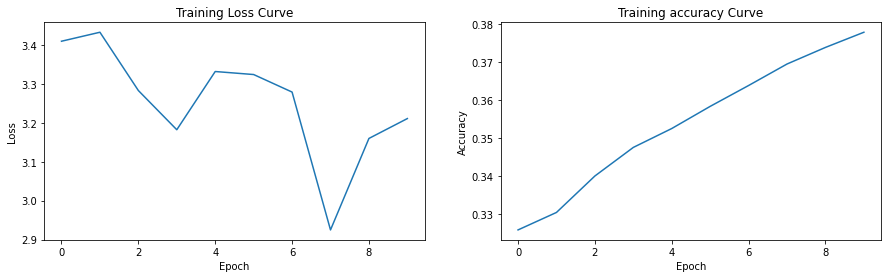

In [32]:
from mxnet import gluon, autograd, ndarray
#TODO: Define a training function which trains the passed network for the given number of epochs using the provided optimizer and criterion
# The function should return the final training loss and the final training accuracy
def train_network(net, train_loader, criterion, trainer, metric, epochs = 10, plot_curve=True):
  #TODO: Define your training loop here
    accs = []
    losses = []
    for epoch in range(epochs):
        for data, label in train_loader:
            data = data.reshape(-1,3*32*32).as_in_context(ctx)
            label = label.as_in_context(ctx)
            with autograd.record():
                output = net(data)
                loss = criterion(output, label).mean()
            loss.backward()
            metric.update(label.as_nd_ndarray(),output.as_nd_ndarray())
            trainer.step(data.shape[0]) # Batch Size     
            acc = metric.get()[1]
        accs.append(acc)
        losses.append(loss.item())
        print(f'epoch: {epoch}; loss: {loss.item():.3f}, accuracy: {acc:.3f}')

    final_training_accuracy = float(np.array(accs).mean()) #TODO: Set this to final training accuracy
    final_training_loss = float(np.array(losses).mean()) #TODO: Set this to final training loss

    # plot curves
    if plot_curve:
        plt.figure(figsize=(15,4))

        plt.subplot(1,2,1)
        plt.plot(range(epochs), losses)
        plt.title('Training Loss Curve')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        
        plt.subplot(1,2,2)
        plt.plot(range(epochs), accs)
        plt.title('Training accuracy Curve')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        
        plt.show()
    
    return final_training_accuracy, final_training_loss


mx.random.seed(18)
# net = construct_net()
# net.initialize(mx.init.Xavier(magnitude=3), ctx=ctx)
# trainer = gluon.trainer.Trainer(net.collect_params(), 'adam', {'learning_rate': .001})
# criterion = gluon.loss.SoftmaxCrossEntropyLoss()
epochs = 10
metric = mx.metric.Accuracy()

lr_training_accuracy, lr_training_loss = train_network(
    net, train_loader, criterion, trainer, metric, epochs)

In [33]:
# Grader Cell : 5 Points
grader.grade('check_lr_train', (lr_training_accuracy, lr_training_loss))

Correct! You earned 8/8 points. You are a star!

Your submission has been successfully recorded in the gradebook.


Is your model learning? Is the loss decreasing? Is it able to classifiy better after training?




### Evaluate Model

Evaluate the model performance on the test set. Compute the cross entropy loss and accuracy on the test set.

Note:  Please don't report false numbers for the accuracy as we will be reviewing these manually and if if there is a manipulation with the accuracy computation, you will get a 0 for the entire section.


In [34]:
def test_model(net, criterion, test_loader, metric):
    #TODO
    losses = []
    metric.reset()
    for data, labels in test_loader:
        data = data.reshape(data.shape[0], -1)
        data = data.as_in_context(ctx)
        labels = labels.as_in_context(ctx)
        predictions = net(data)
        losses.append(criterion(predictions, labels).sum().item())
        metric.update(
            preds=predictions.as_nd_ndarray(), 
            labels=labels.as_nd_ndarray())
    testing_accuracy = float(metric.get()[1]) #TODO: Set this to final testing accuracy
    testing_loss = float(np.array(losses).mean()) #TODO: Set this to final testing loss

    return  testing_loss, testing_accuracy

In [35]:
# metric  =  #TODO: Define an accuracy metric
metric = mx.metric.Accuracy()  
lr_testing_loss, lr_testing_accuracy = test_model(net, criterion, test_loader, metric)

print("Logistic Regression - the testing loss is ", str(lr_testing_loss))
print("Logistic Regression - the testing accuracy is ", str(lr_testing_accuracy))

Logistic Regression - the testing loss is  3.227931022644043
Logistic Regression - the testing accuracy is  0.313373253493014


In [36]:
lr_testing_accuracy

0.313373253493014

In [37]:
# Grader Cell : 5 Points
grader.grade('check_lr_test', (lr_testing_accuracy,lr_testing_loss))

Correct! You earned 8/8 points. You are a star!

Your submission has been successfully recorded in the gradebook.


Does the logistic regression fit well to the data? Think about whether this is underfitting or overfitting? Think about if we need more representational power or we need more regularization to make it better?

## 2.1.2 Feedforward Neural Networks (20 points)

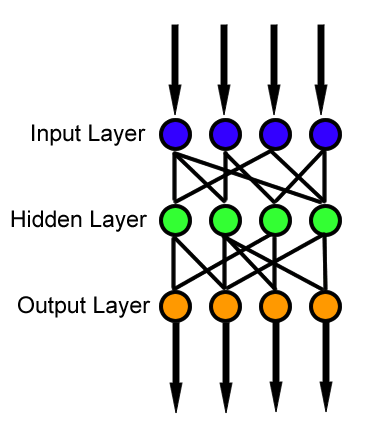

Since logistic regression isn't that great at fitting our classification problem, we need more representation power. We will now define a feedforward neural network


Complete the `create_ff_net` function below to define a feedforward neural network with at least 2 hidden layers. Note that the last layer must have the number of classes as the output size! You will also need to initialize the network, create a new `trainer` object with the parameters of the feedforward network. Use a ReLU activation function for the hidden layers. 


In [38]:
from mxnet import gluon, autograd, ndarray

def construct_ff_net():
    ff_net = nn.Sequential()
    # TODO: Create a feedforward network, experiment with the number of hidden layers and the number of sizes of the hidden layers
    ff_net.add(
        nn.Dense(256),
        nn.BatchNorm(),
        nn.LeakyReLU(0.1),
        nn.Dense(128),
        nn.BatchNorm(),
        nn.LeakyReLU(0.1),
        nn.Dense(train_num_labels) # output_size: num_class 
    )
    return ff_net

ctx =  mx.gpu() if mx.context.num_gpus() else mx.cpu()
net = construct_ff_net()
ff_net = net
#TODO: Initialize the network
ff_net.initialize(mx.init.Xavier(), ctx=ctx)
#TODO: Create a new trainer object for this network
trainer = gluon.trainer.Trainer(ff_net.collect_params(), 'adam', {'learning_rate': 0.01})

Print the model summary for the fully connected network.

In [39]:
x = mx.sym.var('data')
sym = ff_net(x.as_np_ndarray())
mx.viz.print_summary(sym)

________________________________________________________________________________________________________________________
Layer (type)                                        Output Shape            Param #     Previous Layer                  
data(null)                                                                  0                                           
________________________________________________________________________________________________________________________
dense0_fwd(FullyConnected)                                                  256         data                            
________________________________________________________________________________________________________________________
batchnorm0_fwd(BatchNorm)                                                   0           dense0_fwd                      
________________________________________________________________________________________________________________________
leakyrelu0_fwd(LeakyReLU)       

Now train this network using the train network function defined above. Create plots for the training accuracy and training loss vs the number of epochs.


epoch: 0; loss: 1.347, accuracy: 0.462
epoch: 1; loss: 1.203, accuracy: 0.606
epoch: 2; loss: 0.338, accuracy: 0.674
epoch: 3; loss: 1.639, accuracy: 0.716
epoch: 4; loss: 0.506, accuracy: 0.745
epoch: 5; loss: 0.147, accuracy: 0.768
epoch: 6; loss: 1.040, accuracy: 0.786
epoch: 7; loss: 0.434, accuracy: 0.800
epoch: 8; loss: 0.791, accuracy: 0.811
epoch: 9; loss: 0.176, accuracy: 0.822


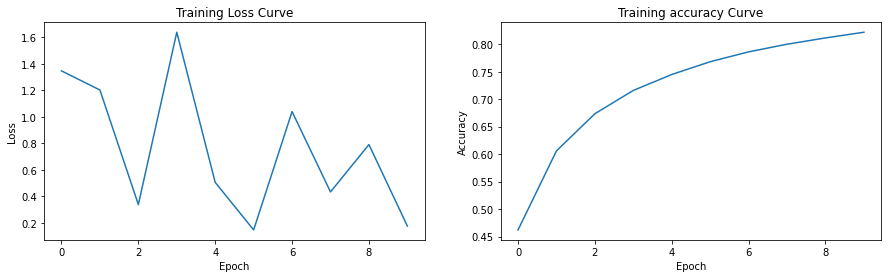

In [40]:
#TODO: Train the feedforward neural network on the training set using the train_network function
epochs = 10
criterion = mx.gluon.loss.SoftmaxCrossEntropyLoss()
metric = mx.metric.Accuracy()

acc, train_loss  = train_network(
    ff_net, train_loader, criterion, trainer, metric, epochs)

ffn_training_loss, ffn_training_accuracy = train_loss, acc

In [41]:
grader.grade('check_ffn_train', (ffn_training_accuracy,ffn_training_loss))

Correct! You earned 10/10 points. You are a star!

Your submission has been successfully recorded in the gradebook.


Once again, evaluate the model performance on the test set. Compute the cross entropy loss and accuracy on the test set

In [42]:
# TODO: Compute performance on the test set using the test_network function created before
ffn_testing_loss, ffn_testing_accuracy = test_model(net, criterion, test_loader, metric)

In [43]:
ffn_testing_loss, ffn_testing_accuracy

(1.3881540298461914, 0.6966067864271457)

In [44]:
grader.grade('check_ffn_test', (ffn_testing_accuracy,ffn_testing_loss))

Correct! You earned 10/10 points. You are a star!

Your submission has been successfully recorded in the gradebook.


Does the feedforward network do better than logistic regression? Play around with the network architecture to see how it affects the performance on both the train and test data.



```
`# This is formatted as code`
```

## 2.1.3 Convoluted Convolutional Neural Networks (25 points)
**So, what are CNNs?**

Convolutional Neural Networks are very similar to Feedforward Neural Networks from the previous section: they are made up of neurons that have learnable weights and biases. Each neuron receives some inputs, performs a dot product and optionally follows it with a non-linearity. The whole network still expresses a single differentiable score function: from the raw image pixels on one end to class scores at the other. 

So what changes? ConvNet architectures make the explicit assumption that the inputs are images, which allows us to encode certain properties into the architecture. These then make the forward function more efficient to implement and vastly reduce the amount of parameters in the network.

If you wanna know more about how CNNs function and see some cool visualizations, we would highly recommend [this](http://cs231n.github.io/convolutional-networks/) page


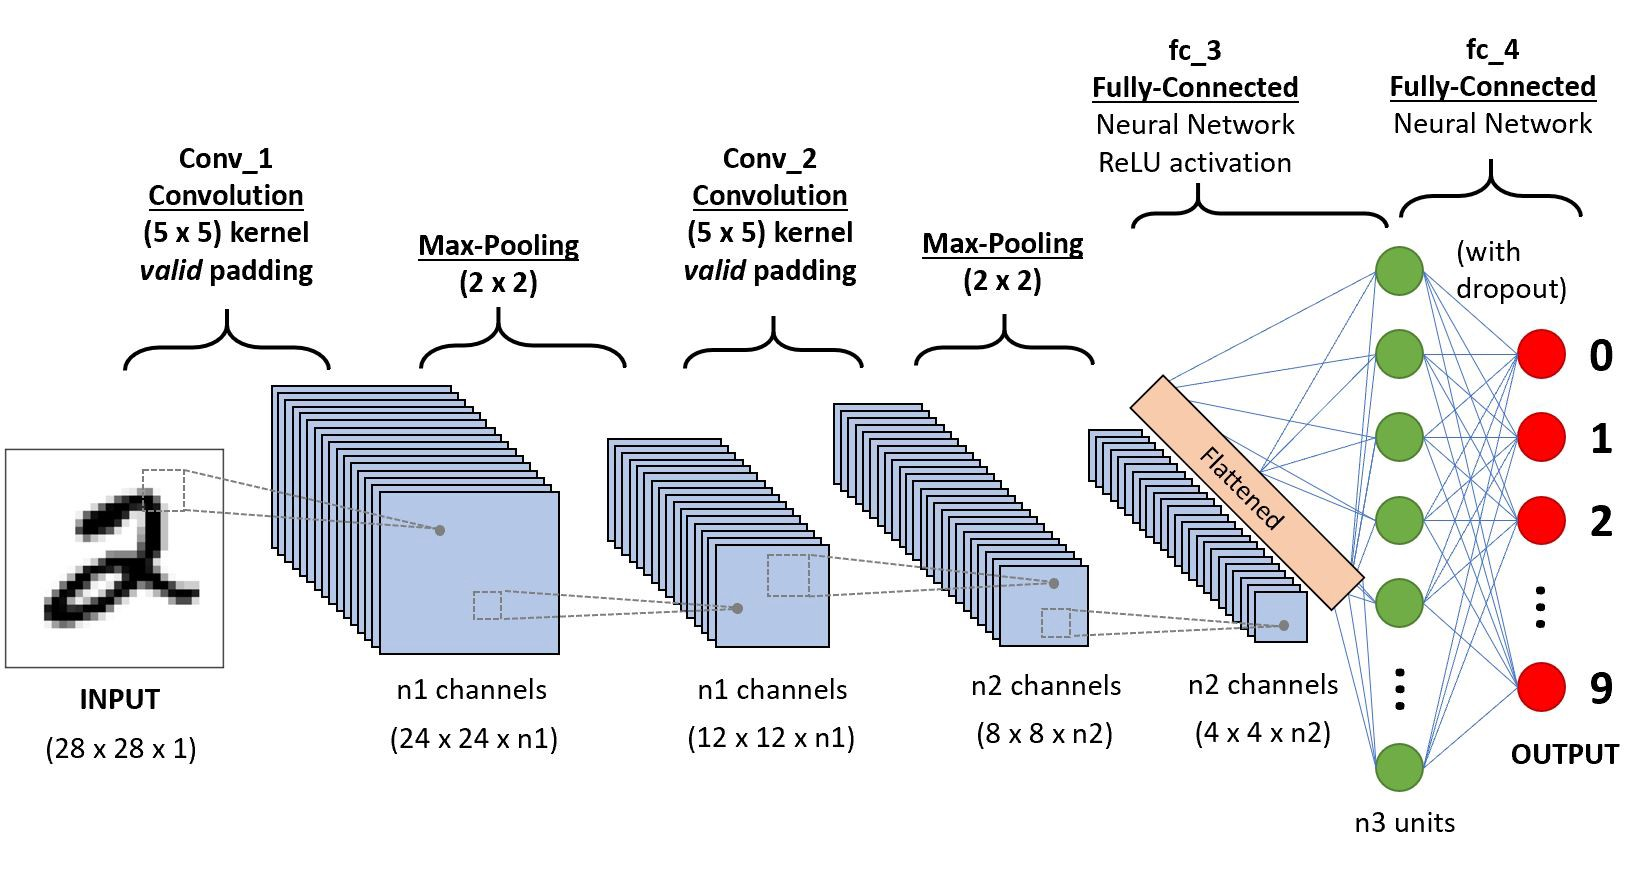


We will define the architecture for the CNN we will be using. The components of CNNs are: 


*   Convolutional Layers
*   Pooling Layers
*   Linear Layers
*   Activation Functions

Define a CNN model with Mxnet and Gluon with a convolutional layer followed by an activation function and a max pool, for one or more layers; then flatten the output from the convolutional layers and pass it through one or more fully connected or 'dense' layers and activation functions after all but the last layer. Note that the output shape from the last layer must be the same as the number of classes.

You can find some examples of this here: https://gluon.mxnet.io/chapter03_deep-neural-networks/mlp-gluon.html#Faster-modeling-with-gluon.nn.Sequential

Some possible activation functions are relu, sigmoid, tanh

In [45]:
import mxnet.ndarray as F

# TODO - construct construct_conv_net() function that returns the CNN network
def construct_conv_net():
    net = nn.Sequential()
    with net.name_scope():
      net.add(
          nn.Conv2D(channels=6, kernel_size=3, activation='relu'),
          nn.BatchNorm(),
          nn.MaxPool2D(pool_size=2, strides=2),
          nn.Conv2D(channels=20, kernel_size=3, activation='relu'),
          nn.Dropout(0.2),
          nn.BatchNorm(),
          nn.MaxPool2D(pool_size=2, strides=2),
          nn.Flatten(),
          nn.Dense(86, activation="relu"),
          nn.Dense(43))
    return net


Once again, we ask you to create a network, initialize it and create a trainer for it.

Create a new trainer object "trainer" for this network with adam optimizer and learning rate of 0.0005



In [46]:
# Epochs
epochs = 25

# Accurcay Metric
metric = mx.metric.Accuracy()

# Set the context to use the available GPUs, otherwise just use a CPU
ctx = mx.gpu() if mx.context.num_gpus() else mx.cpu()

# Save the Network constructed above as cnn
cnn = construct_conv_net()

# Initialize network (cnn), initialize the criterion and the trainer
# TODO - Set up the criterion to train the model (remeber this is a multiclass classification problem)
criterion =  gluon.loss.SoftmaxCrossEntropyLoss()

# TODO: Initialize the network
cnn.initialize(mx.init.Xavier(), ctx=ctx)

# TODO: Create a new trainer object for this network
trainer = gluon.trainer.Trainer(cnn.collect_params(), 'adam', {'learning_rate': 0.0005})

In [47]:
#Grader Cell - Worth 10 points
grader.grade('check_cnn_model', (str(cnn.collect_params()), str(trainer.learning_rate), str(trainer.optimizer)))

Correct! You earned 10/10 points. You are a star!

Your submission has been successfully recorded in the gradebook.


Write another function to train a convolutional neural network on the train 

data given the network, trainer and criterion. Train the CNN for 25 epochs. Plot the training loss and accuracy curves.

Note that there will be a slight difference from training a feedforward network cause here you will feed image information in separate channels as the input, rather than a single flattened input.

epoch: 0; loss: 0.012, accuracy: 0.942
epoch: 1; loss: 0.025, accuracy: 0.943
epoch: 2; loss: 0.005, accuracy: 0.945
epoch: 3; loss: 0.034, accuracy: 0.947
epoch: 4; loss: 0.018, accuracy: 0.948
epoch: 5; loss: 0.092, accuracy: 0.950
epoch: 6; loss: 0.067, accuracy: 0.951
epoch: 7; loss: 0.232, accuracy: 0.953
epoch: 8; loss: 0.003, accuracy: 0.954
epoch: 9; loss: 0.003, accuracy: 0.955
epoch: 10; loss: 0.000, accuracy: 0.956
epoch: 11; loss: 0.005, accuracy: 0.957
epoch: 12; loss: 0.007, accuracy: 0.958
epoch: 13; loss: 0.003, accuracy: 0.959
epoch: 14; loss: 0.094, accuracy: 0.960
epoch: 15; loss: 0.000, accuracy: 0.961
epoch: 16; loss: 0.000, accuracy: 0.961
epoch: 17; loss: 0.003, accuracy: 0.962
epoch: 18; loss: 0.011, accuracy: 0.963
epoch: 19; loss: 0.001, accuracy: 0.964
epoch: 20; loss: 0.044, accuracy: 0.964
epoch: 21; loss: 0.003, accuracy: 0.965
epoch: 22; loss: 0.011, accuracy: 0.966
epoch: 23; loss: 0.000, accuracy: 0.966
epoch: 24; loss: 0.001, accuracy: 0.967


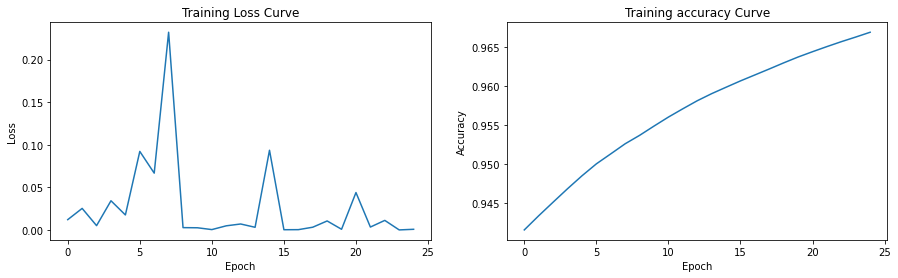

In [51]:
from mxnet import gluon, autograd, ndarray

#TODO: Define a training function which trains the passed network for the given number of epochs using the provided optimizer and criterion
# The function should return the final training loss and the final training accuracy
def train_cnn(net, train_loader, criterion, trainer, metric, epochs = 25, plot_curve=True):
    #TODO: Define your training loop here
    accs = []
    losses = []
    for epoch in range(epochs):
        for data, label in train_loader:
            data = data.as_in_context(ctx)
            label = label.as_in_context(ctx)
            with autograd.record():
                output = net(data)
                loss = criterion(output, label).mean()
            loss.backward()
            trainer.step(data.shape[0])
            metric.update(
                preds=output.as_nd_ndarray(), 
                labels=label.as_nd_ndarray())
            acc = metric.get()[1]
        accs.append(acc)
        losses.append(loss.item())
        print(f'epoch: {epoch}; loss: {loss.item():.3f}, accuracy: {acc:.3f}')

    final_training_accuracy = float(np.array(accs).mean()) #TODO: Set this to final training accuracy
    final_training_loss = float(np.array(losses).mean()) #TODO: Set this to final training loss
    
    # plot curves
    if plot_curve:
        plt.figure(figsize=(15,4))

        plt.subplot(1,2,1)
        plt.plot(range(epochs), losses)
        plt.title('Training Loss Curve')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')

        plt.subplot(1,2,2)
        plt.plot(range(epochs), accs)
        plt.title('Training accuracy Curve')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        
        plt.show()

    return final_training_loss, final_training_accuracy

# TODO: get the training loss and accuracy
mx.random.seed(23)
cnn_training_loss, cnn_training_accuracy = train_cnn(
    cnn, train_loader, criterion, trainer, metric, epochs)

In [52]:
cnn_training_loss, cnn_training_accuracy

(0.026952043175697327, 0.9566620588302612)

In [53]:
grader.grade('check_cnn_train', (cnn_training_accuracy, cnn_training_loss))

Correct! You earned 7/7 points. You are a star!

Your submission has been successfully recorded in the gradebook.


Once again, evaluate the model performance on the test set. Compute the cross entropy loss and accuracy on the test set

In [54]:
# TODO: Compute performance on the test set
# redefine test function
def test_model(net, criterion, test_loader, metric):
    #TODO
    losses = []
    accuracies = []
    metric.reset()
    for data, labels in test_loader:
        data = data.as_in_context(ctx)
        labels = labels.as_in_context(ctx)
        output = net(data)
        loss = criterion(output, labels).item()
        metric.update(
            preds=output.as_nd_ndarray(), 
            labels=labels.as_nd_ndarray())
        accuracy = metric.get()[1]
        losses.append(loss)
        accuracies.append(accuracy)
    testing_accuracy = float(np.array(accuracies).mean()) #TODO: Set this to final testing accuracy
    # testing_loss = sum(losses) / len(test_loader) #TODO: Set this to final testing loss
    testing_loss = float(np.array(losses).mean()) #TODO: Set this to final testing loss
    
    return  testing_loss, testing_accuracy

In [55]:
# TODO: Compute performance on the test set
# mx.random.seed(12)
cnn_testing_loss, cnn_testing_accuracy = test_model(cnn, criterion, test_loader, metric)

In [56]:
cnn_testing_loss, cnn_testing_accuracy

(0.5087037682533264, 0.8867760300636292)

In [57]:
grader.grade('check_cnn_test', (cnn_testing_accuracy, cnn_testing_loss))

Correct! You earned 8/8 points. You are a star!

Your submission has been successfully recorded in the gradebook.


How does the CNN perform? Does it out perform feedforward network?

Print out the number of learned parameters for the CNN and for the FFN. Does the CNN have more parameters? Think about how this links to performance and how CNN is so powerful?

## 2.1.4 Confusion Matrix (6pts)

We want to give you some insight into how you can further analyze the performance of the classification model you have trained. 

Upto now we have only used accuracy as a measure of performance. Although accuracy is simple and widely used meaure, it has it's flaws.

Assume that we are trying to train a model to detect a rare disease from CT images of patients. For simplicity assume that this rare disease have 1% incidence rate.

In this situation, if we train a degenerative model which always predicts that the patient does not have the disease, the accuracy is very high, 99%! Obviously in this case accuracy is not a good measure of performance of the model.

This is where confusion matrix and related metrics are introduced.

So a confusion matrix is a C x C 2D matrix (Where C is number of labels of your dataset). Where the rows denote the actual labels and columns denote the predicted labels.

In (i, j)th element of the confusion matrix, it contains the number of data where it's actual label is i but the model predicted as label j.

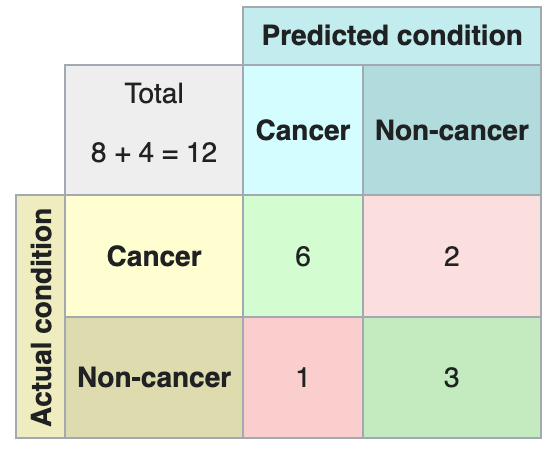

The provided image is an example of a confusion matrix for binary classification (C = 2), but you can easily imagine this scaling up to C > 2.

From this confusion matrix we can get all sorts of useful metrics such as False Positive Rate (FPR), False Negative Rate (FNR), Recall, Precision, etc... If you are interested in learning more about confusion matrix and related metrics [this wikipedia page](https://en.wikipedia.org/wiki/Confusion_matrix#cite_note-11) is a good place to look at. 







Create a confusion matrix for the test dataset using the CNN model you have trained above. And save the confusion matrix as a pandas dataframe called "confusion_matrix_df"

In [58]:
import pandas as pd
import numpy as np
# TODO - create the confusion matrix and save it as pandas dataframe confusion_matrix_df
confusion_matrix = np.zeros((43, 43))
for data, label in test_loader:
    data = data.as_in_context(ctx)
    # label = label.as_in_context(ctx)
    label = label[0]
    output = net(data)
    pred = np.argmax(output.as_np_ndarray()).item()
    # print(label, pred)
    confusion_matrix[int(label), int(pred)] += 1 

confusion_matrix = [r.tolist() for r in confusion_matrix]
confusion_matrix_df = pd.DataFrame(data=confusion_matrix)

In [59]:
grader.grade('check_confusion_matrix', (str(type(confusion_matrix_df)), confusion_matrix_df.shape, confusion_matrix_df.to_numpy().sum()))

Correct! You earned 6/6 points. You are a star!

Your submission has been successfully recorded in the gradebook.


## Visualizing Confusion Matrix (3 pts)

Implement the code to visualize the confusion matrix you have created above. This section will be manually graded

Suggested library is using Seaborn heatmap. Take a look at the parameter "annot"

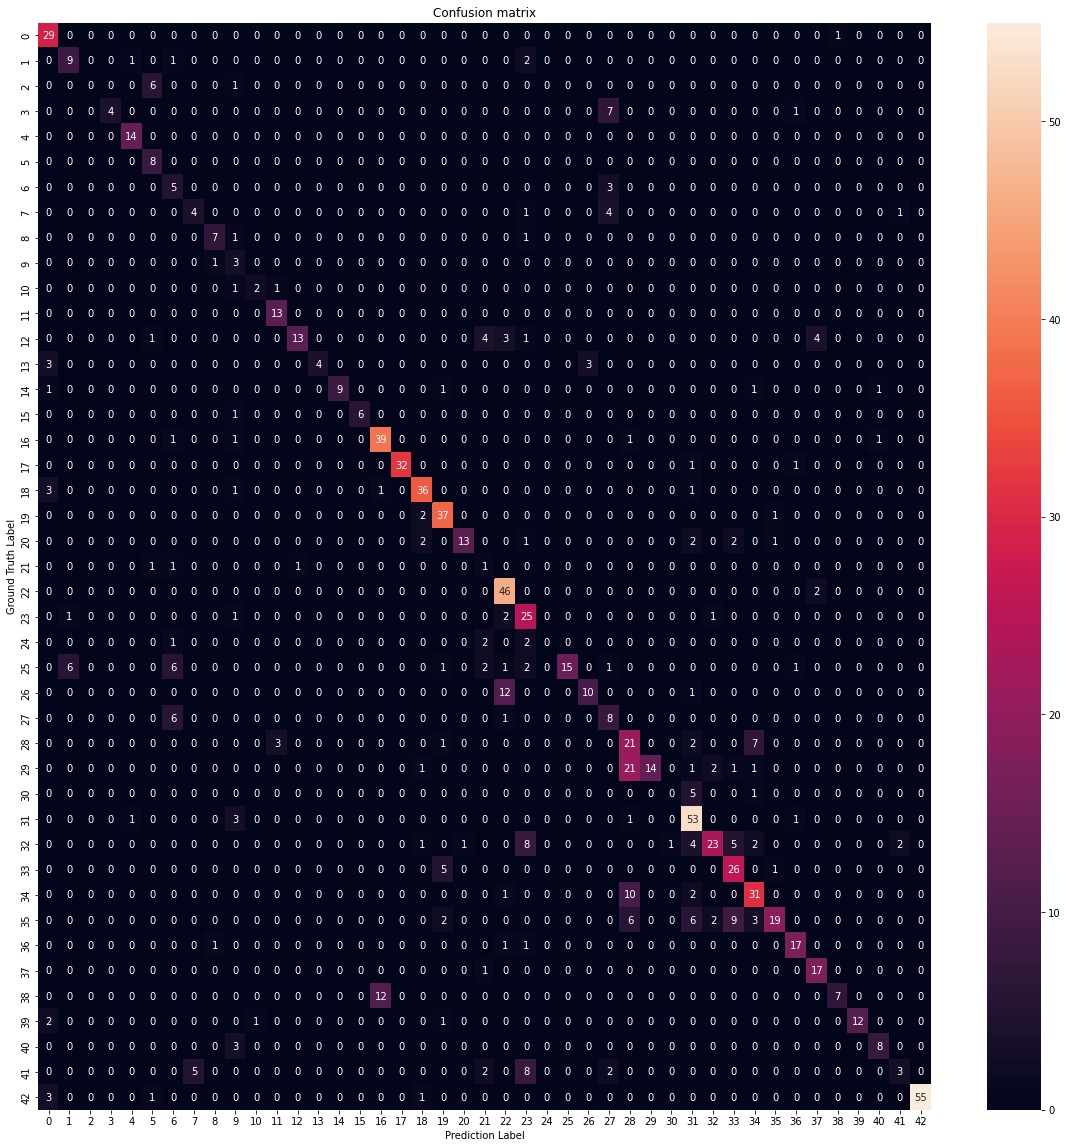

In [60]:
# TODO - create visualization of the Confusion Matrix
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
# df_cm = pd.DataFrame(confusion_matrix_df, index=range(43), columns=range(43))
plt.figure(figsize = (20,20))
sns.heatmap(confusion_matrix_df, annot=True)
plt.title("Confusion matrix")
plt.ylabel('Ground Truth Label')
plt.xlabel('Prediction Label')
plt.show()

We can see that since our CNN model have relatively high accuracy, lots of diagonal elements have high values.

However, if we look closely, some of the diagonal elements have value zero. This means that the trained CNN model was unable to correctly classify any of the data with those labels. 

From here we might be able to figure out some potential reasons for this and make changes to the model architecture.

HW FINISHED! As always, submit both homework5.ipynb and homework5.py to Gradescope!